In [9]:
import os
import numpy as np
import scipy.io as sio

# Load the data from the specified .mat file
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)
tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']



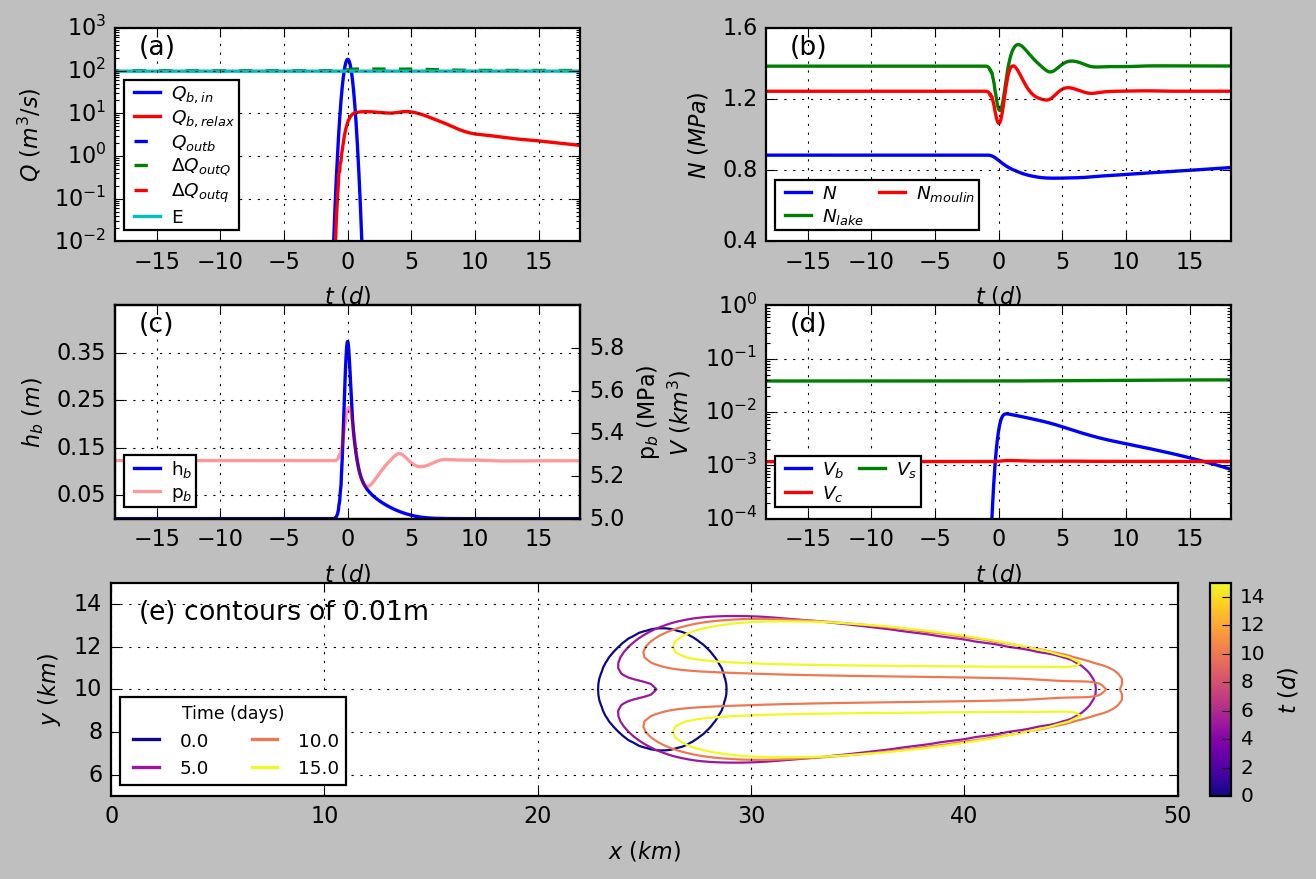

In [ ]:
# This is a draft of the plot showing the evolution of the blister with an efficient subglacial hydrology model
# with moulin input = 100 m3/s, leading to a channel at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+5,365*3+10, 365*3+15])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(0.4, 1.6)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax5.contour(xx, yy, ps_hb * vhb[i], levels=[0.01], colors=[color_i])

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('$t~(d)$', fontsize=10)
cbar.ax.tick_params(labelsize=9)
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=cmap(norm(v)), linewidth=1.5)
           for v in vt]
labels  = [f"{v:.1f}" for v in vt]
ax5.legend(handles, labels,
           title='Time (days)',
           loc='lower left',
           fontsize='small',
           ncol=2,
           bbox_to_anchor=(0.0, 0.01))

ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) contours of $0.01$m', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
plt.show()

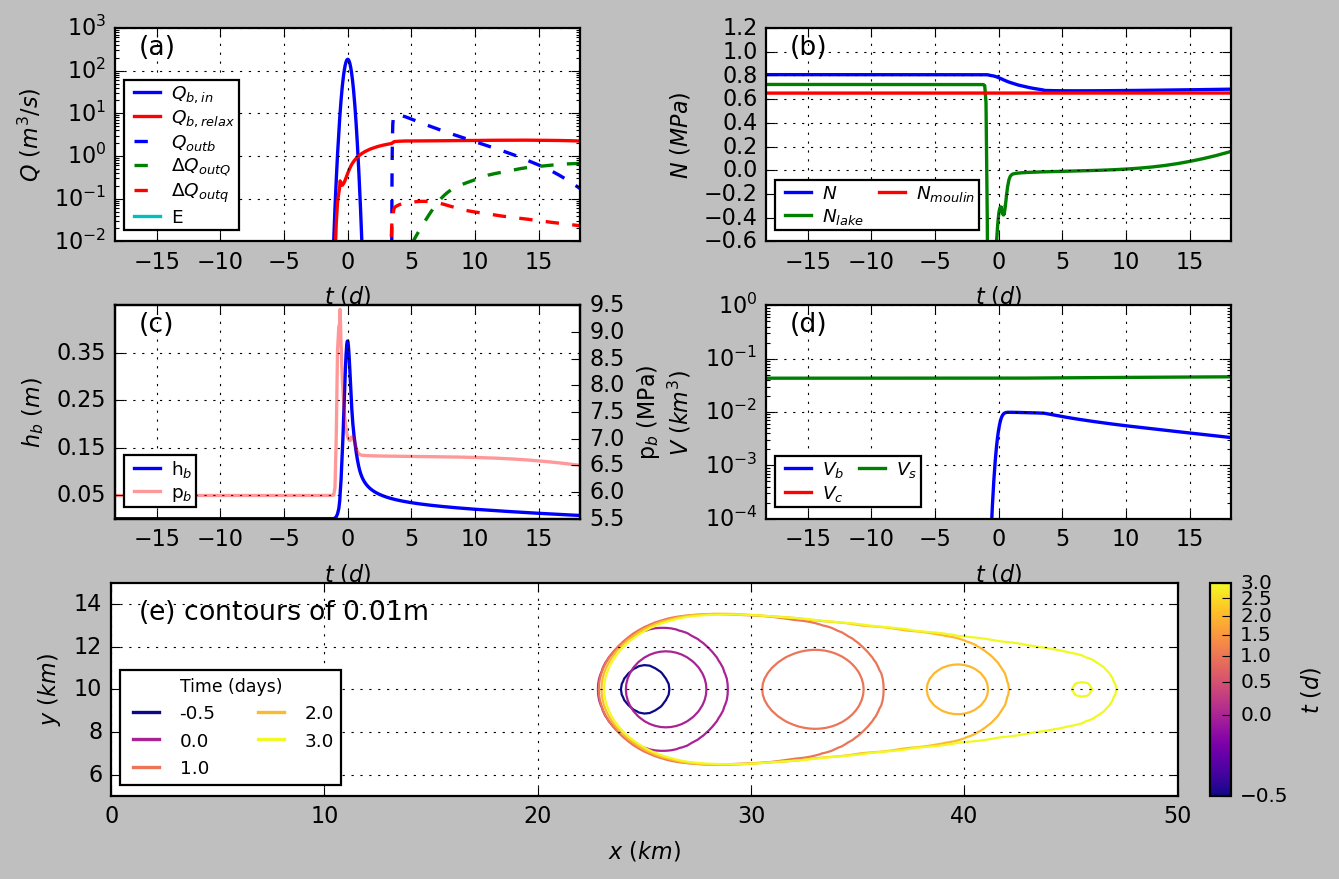

In [ ]:
# This is a draft of the plot showing the evolution of the blister with an inefficient subglacial hydrology model
# with moulin input = 0 m3/s, with almost no channel and sheet flow at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_0m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3-0.5, 365*3, 365*3+1, 365*3+2, 365*3+3])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left', bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
# ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(-0.6, 1.2)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
# ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
# ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=0.5, vmin=np.min(vt), vmax=np.max(vt))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    CS = ax5.contour(xx, yy, ps_hb * vhb[i], levels=[0.01, 0.2], colors=[color_i])

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('$t~(d)$', fontsize=10)
cbar.ax.tick_params(labelsize=9)
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=cmap(norm(v)), linewidth=1.5)
           for v in vt]
labels  = [f"{v:.1f}" for v in vt]
ax5.legend(handles, labels,
           title='Time (days)',
           loc='lower left',
           fontsize='small',
           ncol=2,
           bbox_to_anchor=(0.0, 0.01))

ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) contours of $0.01$m', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
plt.show()

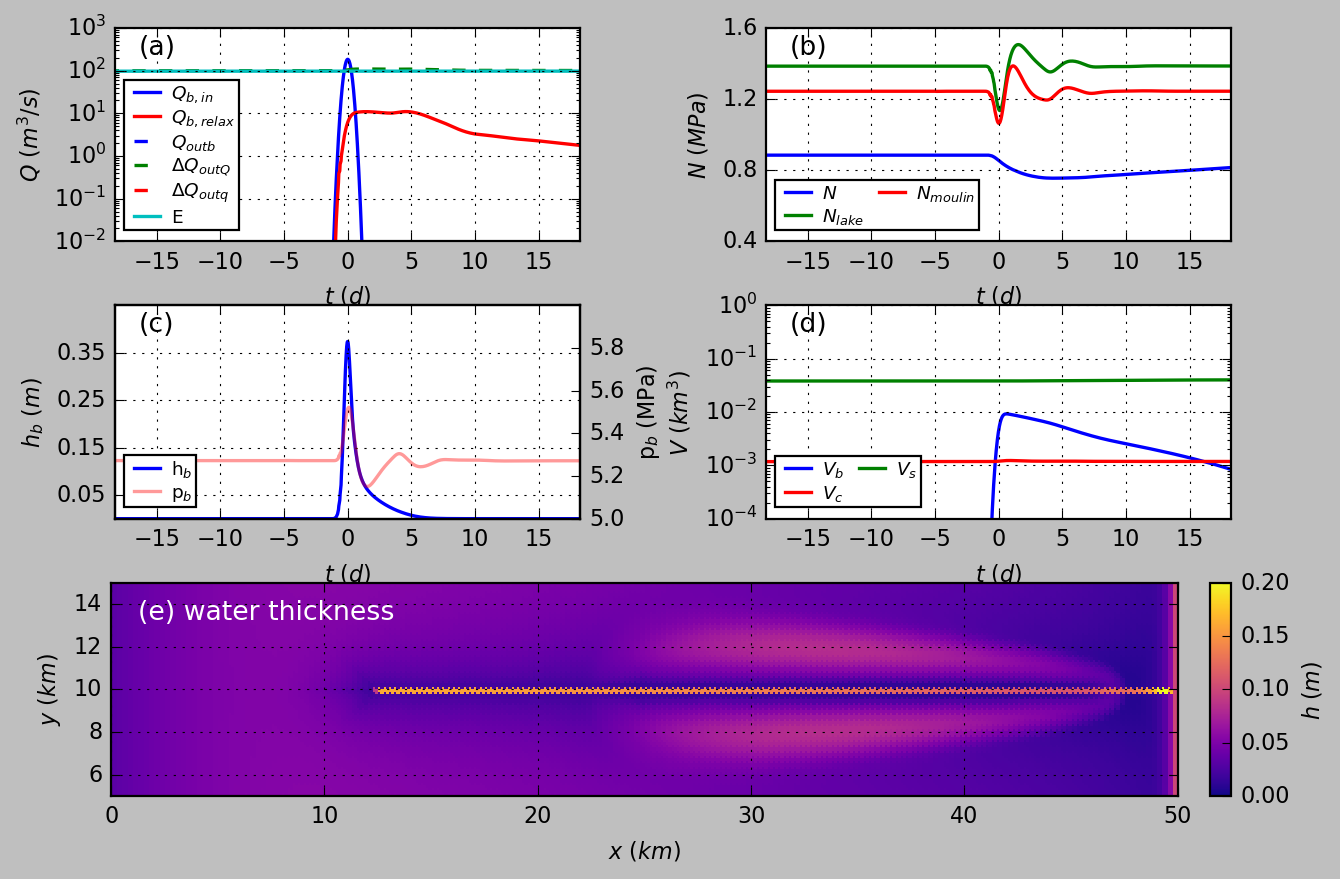

In [590]:
# This is a draft of the plot showing the evolution of the blister with an efficient subglacial hydrology model
# with moulin input = 100 m3/s, leading to a channel at the center line of the glacier.
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

pp_c8 = np.float64(pp['c8'])
# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())
eI = int(gg['eI'].item())
eJ = int(gg['eJ'].item())
cI = int(gg['cI'].item())
cJ = int(gg['cJ'].item())

nmeanx = gg['nmeanx'].item()
nmeany = gg['nmeany'].item()
nmeans = gg['nmeans'].item()
nmeanr = gg['nmeanr'].item()
ein = gg['ein'].item()
fin = gg['fin'].item()
cin = gg['cin'].item()
Dx = np.float64(gg['Dx'].item())
Dy = np.float64(gg['Dy'].item())
Ds = np.float64(gg['Ds'].item())
Dr = np.float64(gg['Dr'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+1,365*3+5, 365*3+10])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vhc = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    pb_val   = np.float64(vv['pb'].item())

    Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
    Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
    Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
    Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
    vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
    vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
    vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
    vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

# --- Set up figure with GridSpec ----------------------------------------
fig = plt.figure(figsize=(9, 6), constrained_layout=False)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.4, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 10
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

# Panel (a) — flux
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax1.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax1.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax1.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax1.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax1.plot(t-td, E,       '-',    linewidth=1.5, label='E')
ax1.set_yscale('log')
ax1.set_xlim(tmin_d-td, tmax_d-td)
ax1.set_xlabel('$t~(d)$')
ax1.set_ylim(1e-2, 1e3)
ax1.set_ylabel(r'$Q~(m^3/s)$')
ax1.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize='small',
           labelspacing=0.2, handletextpad=0.3, borderpad=0.2)
ax1.text(0.05, 0.85, '(a)', transform=ax1.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax1.grid()

# Panel (b) — effective pressure
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t-td, N/1e6, '-', linewidth=1.5, label='$N$')
ax2.plot(t-td, pts_N_lake/1e6, '-', linewidth=1.5, label='$N_{lake}$')
ax2.plot(t-td, pts_N_moulin/1e6, '-', linewidth=1.5, label='$N_{moulin}$')
ax2.set_xlim(tmin_d-td, tmax_d-td)
ax2.set_xlabel('$t~(d)$')
ax2.set_yticks(np.arange(0.4, 1.6, 0.4))
ax2.set_ylim(0.4, 1.6)
ax2.set_ylabel('$N~(MPa)$')
ax2.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax2.text(0.05, 0.85, '(b)', transform=ax2.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax2.grid()


ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(t-td, pts_hb_lake, 'b-', linewidth=1.5, label='h$_b$')
ax3.set_ylabel('$h_b~(m)$')
ax3.set_yticks(np.arange(0.05, 0.45, 0.1))
ax3.set_ylim(0.0, 0.45)
ax3.set_xlim(tmin_d-td, tmax_d-td)

ax3b = ax3.twinx()
ax3b.plot(t-td, pts_phi_lake/1e6, 'r-', linewidth=1.5, label='p$_b$', alpha=0.4)
ax3b.set_ylabel('p$_b$ (MPa)')
ax3b.set_yticks(np.arange(5.0, 6.0, 0.2))
ax3b.set_ylim(5.0, 6.0)

ax3.set_xlabel('$t~(d)$')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3b.legend(lines1 + lines2, labels1 + labels2, loc='lower left', ncol=1, bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax3.text(0.05, 0.85, '(c)', transform=ax3.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax3.grid()

# Panel (d) — V_b, V_c, V_s
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(t-td, V_b/1e9, 'b-', linewidth=1.5, label='$V_b$')
ax4.plot(t-td, V_c/1e9, 'r-', linewidth=1.5, label='$V_c$')
ax4.plot(t-td, V_s/1e9, 'g-', linewidth=1.5, label='$V_s$')
ax4.set_xlim(tmin_d-td, tmax_d-td)
ax4.set_xlabel('$t~(d)$')
ax4.set_yscale('log')
ax4.set_ylim(1e-4, 1e0)
ax4.set_ylabel('$V~(km^3)$', fontsize=10)
ax4.legend(loc='lower left', ncol=2,  bbox_to_anchor=(0.0, 0.01),
           frameon=True, fontsize='small', labelspacing=0.2,
           handletextpad=0.3, borderpad=0.2, columnspacing=0.5)
ax4.text(0.05, 0.85, '(d)', transform=ax4.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False)
ax4.grid()

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=10)

# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False) # Hide original axes

# Get positions of the axes above to align with
pos_left = ax3.get_position()
pos_right = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Define new positions for panel (e) and its colorbar
colorbar_width = 0.015
pad = 0.01
ax5_width = (pos_right.x1 - pos_left.x0) - colorbar_width - pad
ax5_pos = [pos_left.x0, pos_bottom.y0, ax5_width, pos_bottom.height]
cax_pos = [pos_left.x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)
cax = fig.add_axes(cax_pos)

import matplotlib.cm as cm
cmap = plt.cm.plasma
norm = PowerNorm(gamma=1.0, vmin=0, vmax=0.2)

for i in range(len(nums)):
    color_i = cmap(norm(vt[i]))
    pc = ax5.pcolormesh(xx, yy,
                        ps_hb * vhb[i] + ps_h * vhs[i] + ps_h * vhc[i],
                        cmap=cmap, norm=norm, shading='auto')
    pc.set_edgecolor('face')  # Avoid grid lines

# set up colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)


ax5.set_xlim(0, 50)
ax5.set_ylim(5, 15)
ax5.set_xlabel('$x~(km)$')
ax5.set_ylabel('$y~(km)$')

ax5.grid()
pos3 = ax3.get_position()
pos4 = ax4.get_position()
pos5 = ax5.get_position()

# Set the left and right boundaries of ax5 to match ax3 and ax4
ax5.set_position([pos3.x0-0.02, pos5.y0, pos4.x1 - pos3.x0, pos5.height])
ax5.set_aspect('equal', adjustable='box')
ax5.text(0.025, 0.8, '(e) water thickness', transform=ax5.transAxes,
         ha='left', va='bottom', fontsize=12, clip_on=False, color='white')
plt.show()

In [6]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
# backgroud field with no lake input
casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V0e7_test'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)
tt = raw['tt']
ps = raw['ps']
ps_t   = np.float64(ps['t'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])
tt_t      = np.float64(tt['t'])
t0 = (ps_t / (24*60*60)) * tt_t        # days
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
Q_out_b0 = ps_Q0 * tt_Q_outb
Q_out_Q0 = ps_Q  * tt_Q_outQ
Q_out_q0 = ps_Q  * tt_Q_outq

casename = 'n2d_100m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

pp_c8 = np.float64(pp['c8'])
# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = np.float64(np.interp(t, t0, Q_out_Q0))
Q_out_q0_interp = np.float64(np.interp(t, t0, Q_out_q0))

Q_out_b = ps_Q0 * tt_Q_outb
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())
eI = int(gg['eI'].item())
eJ = int(gg['eJ'].item())
cI = int(gg['cI'].item())
cJ = int(gg['cJ'].item())

nmeanx = gg['nmeanx'].item()
nmeany = gg['nmeany'].item()
nmeans = gg['nmeans'].item()
nmeanr = gg['nmeanr'].item()
ein = gg['ein'].item()
fin = gg['fin'].item()
cin = gg['cin'].item()
Dx = np.float64(gg['Dx'].item())
Dy = np.float64(gg['Dy'].item())
Ds = np.float64(gg['Ds'].item())
Dr = np.float64(gg['Dr'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3, 365*3+1,365*3+5, 365*3+15])
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vhc = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    pb_val   = np.float64(vv['pb'].item())

    Sx_val = nmeanx.dot(np.float64(vv['Sx'].item()))
    Sy_val = nmeany.dot(np.float64(vv['Sy'].item()))
    Ss_val = nmeans.dot(np.float64(vv['Ss'].item()))
    Sr_val = nmeanr.dot(np.float64(vv['Sr'].item()))

    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vpb = np.array(np.reshape(pb_val, (nI, nJ), order='F'), dtype=np.float64)
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vSx = np.array(np.reshape(Sx_val, (nI, nJ), order='F'), dtype=np.float64)
    vSy = np.array(np.reshape(Sy_val, (nI, nJ), order='F'), dtype=np.float64)
    vSs = np.array(np.reshape(Ss_val, (nI, nJ), order='F'), dtype=np.float64)
    vSr = np.array(np.reshape(Sr_val, (nI, nJ), order='F'), dtype=np.float64)
    vhc.append(np.reshape(pp_c8*(Sx_val*Dx + Sy_val*Dy + Ss_val*Ds + Sr_val*Dr)/(Dx*Dy), (nI, nJ), order='F'))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
vt = np.array(vt, dtype=np.float64)-td

fig = plt.figure(figsize=(9, 6), dpi=600)
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.1, hspace=0.3)
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8
%config InlineBackend.figure_format = 'retina'  # high res for retina displays

xa = 10 
xb = 50
ya = 0
yb = 20
# ================= Panel (a): blister at time a =================
ax1 = fig.add_subplot(gs[0, 0])
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=1e-3, vmax=5e-1)
cmap = plt.cm.Blues
pc = ax1.pcolormesh(xx, yy,
                    ps_hb * vhb[0] + ps_h * vhs[0] + ps_h * vhc[0],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
# Plot contour lines for the blister alone
# contour_lines = ax1.contour(xx, yy, ps_hb * vhb[0], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax1.clabel(
#     contour_lines,
#     inline=True,
#     fontsize=6,
#     fmt='%1.2f',
#     inline_spacing=2,
#     manual=[(20, 5), (27, 12)],# 手动指定少量标签位置
# )
contour_lines = ax1.contour(xx, yy, ps_phi/1e6*vphi1[0], colors='w', linewidths=0.5, linestyles='-')
ax1.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
# plot the moulin location
ax1.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax1.text(0.025, 0.9, '(a) $t=$ '+ f'${vt[0]:.1f}$ d', transform=ax1.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax1.set_xlim(xa, xb)
ax1.set_ylim(ya, yb)
# ax1.set_xlabel('$x~(km)$')
ax1.set_ylabel('$y~(km)$')
ax1.set_aspect('equal')
ax1.grid()

# ================= Panel (b): blister at time b ================
ax2 = fig.add_subplot(gs[0, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax2.pcolormesh(xx, yy,
                    ps_hb * vhb[1] + ps_h * vhs[1] + ps_h * vhc[1],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax2, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax2.contour(xx, yy, ps_hb * vhb[1], levels=[0.01, 0.2], colors='w', linewidths=0.5, linestyles='-')
# ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax2.contour(xx, yy, ps_phi/1e6*vphi1[1], colors='w', linewidths=0.5, linestyles='-')
ax2.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax2.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax2.text(0.025, 0.9, '(b) $t=$ '+ f'${vt[1]:.1f}$ d', transform=ax2.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')
ax2.set_xlim(xa, xb)
ax2.set_ylim(ya, yb)
# ax2.set_xlabel('$x~(km)$')
# ax2.set_ylabel('$y~(km)$')
ax2.set_aspect('equal')
ax2.grid()

# ================= Panel (c): blister at time c ================
ax3 = fig.add_subplot(gs[1, 0])
cmap = plt.cm.Blues
pc = ax3.pcolormesh(xx, yy,
                    ps_hb * vhb[2] + ps_h * vhs[2] + ps_h * vhc[2],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')    
# Plot contour lines for the blister alone
# contour_lines = ax3.contour(xx, yy, ps_hb * vhb[2], levels=[0.01, 0.05], colors='w', linewidths=0.5, linestyles='-')
# ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax3.contour(xx, yy, ps_phi/1e6*vphi1[2], colors='w', linewidths=0.5, linestyles='-')
ax3.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax3.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax3.text(0.025, 0.9, '(c) $t=$ '+ f'${vt[2]:.1f}$ d', transform=ax3.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax3.set_xlim(xa, xb)
ax3.set_ylim(ya, yb)
ax3.set_xlabel('$x~(km)$')
ax3.set_ylabel('$y~(km)$')
ax3.set_aspect('equal')
ax3.grid()

# ================= Panel (d): blister at time d ================
ax4 = fig.add_subplot(gs[1, 1])
cmap = plt.cm.Blues
# Create a color mesh for the total water thickness
pc = ax4.pcolormesh(xx, yy,
                    ps_hb * vhb[3] + ps_h * vhs[3] + ps_h * vhc[3],  # 使用最后一个时间步
                    cmap=cmap, norm=norm, shading='auto')
pc.set_edgecolor('face')
cbar = fig.colorbar(pc, ax=ax4, orientation='vertical', shrink=0.95, pad=0.04)
cbar.set_label('$h\\;(m)$')
cbar.ax.tick_params(labelsize=10)   
# Plot contour lines for the blister alone
# contour_lines = ax4.contour(xx, yy, ps_hb * vhb[3], levels=[0.01, 0.1], colors='w', linewidths=0.5, linestyles='-')
# ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
contour_lines = ax4.contour(xx, yy, ps_phi/1e6*vphi1[3], colors='w', linewidths=0.5, linestyles='-')
ax4.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.2f')
ax4.plot(12.5, 10, 'wo', markersize=4, label='moulin')

ax4.text(0.025, 0.9, '(d) $t=$ '+ f'${vt[3]:.1f}$ d', transform=ax4.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False, color='white')

ax4.set_xlim(xa, xb)
ax4.set_ylim(ya, yb)
ax4.set_xlabel('$x~(km)$')
# ax4.set_ylabel('$y~(km)$')
ax4.set_aspect('equal')
ax4.grid()

# ============== Panel (e): Flux (last row: spanning both columns) ==============
# Panel (e) — combined h/S at the lake (bottom merged)
ax5 = fig.add_subplot(gs[2, :])
ax5.set_visible(False)  # Hide original axes

# Get positions of the axes above to align with
pos_left   = ax3.get_position()
pos_right  = ax4.get_position()
pos_bottom = gs[2, :].get_position(fig)

# Compute full available width
full_width = pos_right.x1 - pos_left.x0

# Shrink factor (e.g. 70% of full width)
shrink_factor = 1
ax5_width = full_width * shrink_factor

# Center the shrunken panel horizontally
ax5_x0 = pos_left.x0 + (full_width - ax5_width)/2
ax5_pos = [ax5_x0, pos_bottom.y0, ax5_width+0.02, pos_bottom.height]

# Colorbar axes to the right of the shrunken panel
pad = 0.01
colorbar_width = 0.015
cax_pos = [ax5_x0 + ax5_width + pad, pos_bottom.y0, colorbar_width, pos_bottom.height]

# Create new axes with the calculated positions
ax5 = fig.add_axes(ax5_pos)

ax5.plot(t-td, Q_b_in, 'b-',    linewidth=1.5, label='$Q_{b,in}$')
ax5.plot(t-td, Q_b_dec,'r-',    linewidth=1.5, label='$Q_{b,relax}$')
ax5.plot(t-td, Q_out_b,'--',   linewidth=1.5, label='$Q_{outb}$')
ax5.plot(t-td, Q_out_Q - Q_out_Q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outQ}$')
ax5.plot(t-td, Q_out_q - Q_out_q0_interp, '--', linewidth=1.5, label=r'$\Delta Q_{outq}$')
ax5.plot(t-td, E,       '-',    linewidth=1.5, label='E')

# vertical lines for time points in (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
for i,t_val in enumerate(vt):
    ax5.axvline(t_val, ymin=1e-6, ymax=1e5, color='k', linestyle='--', linewidth=1.0, alpha=1.0, dashes=(2, 2))
    ax5.text(t_val, 1e3, labels[i], ha='center', va='bottom', fontsize=8, color='k')

ax5.set_yscale('log')
ax5.set_xlim(tmin_d-td, tmax_d-td)
ax5.set_xlabel('$t~(d)$')
ax5.set_ylim(1e-2, 1e3)
ax5.set_ylabel(r'$Q~(m^3/s)$')
ax5.text(0.025, 0.9, '(e) fluxes', transform=ax5.transAxes,
         ha='left', va='top', fontsize=10, clip_on=False)
ax5.legend(loc='lower left',  bbox_to_anchor=(0.0, 0.01), frameon=True, fontsize=8, ncol=2,
           labelspacing=0.4, handletextpad=0.3, borderpad=0.2)
ax5.grid(alpha=0.5)

plt.show()